In [16]:
import os
import openai
import glob

from IPython.display import display, Code, Markdown
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pymysql
import numpy as np
import pandas as pd
import json
import inspect
import re
#from bs4 import BeautifulSoup
import dateutil.parser as parser
import sys
sys.path.insert(0, '.\\functions\\untested functions')
sys.path.insert(0, '.\\functions\\tested functions')
from dotenv import load_dotenv

# 加载.env文件
load_dotenv()

#openai.api_key = os.getenv("OPENAI_API_KEY")
import warnings
warnings.filterwarnings("ignore")

from io import BytesIO

# 添加 OpenAI v1.0+ 的导入
from openai import OpenAI
client = OpenAI(
    api_key="sk-dd65d754d561467fa8e43efd803dfbc0",
    base_url="https://dashscope.aliyuncs.com/compatible-mode/v1"  # 注意：新版SDK推荐使用 base_url 而不是 api_base
)
model="deepseek-v3"
def clean_json_string(text):
    """
    简洁版本：去除JSON代码块标记
    
    参数:
        text (str): 原始字符串
        
    返回:
        str: 清理后的字符串
    """
    # 去除开头的 ```json
    if text.startswith('```json'):
        text = text[7:]
    elif text.startswith('```'):
        text = text[3:]
    
    # 去除结尾的 ```
    if text.endswith('```'):
        text = text[:-3]
    
    return text.strip()


def run_conversation(messages, functions_list=None, model="deepseek-v3"):
    """
    能够自动执行外部函数调用的Chat对话模型
    :param messages: 必要参数，字典类型，输入到Chat模型的messages参数对象
    :param functions_list: 可选参数，默认为None，可以设置为包含全部外部函数的列表对象
    :param model: Chat模型，可选参数，默认模型为gpt-4
    :return：Chat模型输出结果
    """
    # 如果没有外部函数库，则执行普通的对话任务
    if functions_list == None:
        response = client.chat.completions.create(
                        model=model,
                        messages=messages,
                        )
        response_message = response.choices[0].message
        final_response = response_message.content
        
    # 若存在外部函数库，则需要灵活选取外部函数并进行回答
    else:
        # 创建functions对象
        functions = auto_functions(functions_list)
        # 创建外部函数库字典
        available_functions = {func.__name__: func for func in functions_list}

        # first response
        response = client.chat.completions.create(
                        model=model,
                        messages=messages,
                        functions=functions,
                        function_call="auto")
        response_message = response.choices[0].message

        # 判断返回结果是否存在function_call，即判断是否需要调用外部函数来回答问题
        if response_message.function_call:
            # 需要调用外部函数
            # 获取函数名
            function_name = response_message.function_call.name
            # 获取函数对象
            fuction_to_call = available_functions[function_name]
            # 获取函数参数
            function_args = json.loads(response_message.function_call.arguments)
            # 将函数参数输入到函数中，获取函数计算结果
            function_response = fuction_to_call(**function_args)

            # messages中拼接first response消息
            messages.append(response_message)  
            # messages中拼接函数输出结果
            messages.append(
                {
                    "role": "function",
                    "name": function_name,
                    "content": function_response,
                }
            )  
            # 第二次调用模型
            second_response = client.chat.completions.create(
                model=model,
                messages=messages,
            )  
            # 获取最终结果
            final_response = second_response.choices[0].message.content
        else:
            final_response = response_message.content
    
    return final_response

def auto_functions(functions_list):
    """
    Chat模型的functions参数编写函数
    :param functions_list: 包含一个或者多个函数对象的列表；
    :return：满足Chat模型functions参数要求的functions对象
    """
    def functions_generate(functions_list):
        # 创建空列表，用于保存每个函数的描述字典
        functions = []
        
        def chen_ming_algorithm(data):
            """
            陈明算法函数，该函数定义了一种特殊的数据集计算过程
            :param data: 必要参数，表示带入计算的数据表，用字符串进行表示
            :return：陈明函数计算后的结果，返回结果为表示为JSON格式的Dataframe类型对象
            """
            df_new = pd.read_json(data)
            res = np.sum(df_new, axis=1) - 1
            return res.to_json(orient='records')
        
        chen_ming_function_description = inspect.getdoc(chen_ming_algorithm)
        
        chen_ming_function_name = chen_ming_algorithm.__name__
        
        chen_ming_function = {"name": "chen_ming_algorithm",
                              "description": "用于执行陈明算法的函数，定义了一种特殊的数据集计算过程",
                              "parameters": {"type": "object",
                                             "properties": {"data": {"type": "string",
                                                                     "description": "执行陈明算法的数据集"},
                                                           },
                                             "required": ["data"],
                                            },
                             }

        
        # 对每个外部函数进行循环
        for function in functions_list:
            # 读取函数对象的函数说明
            function_description = inspect.getdoc(function)
            # 读取函数的函数名字符串
            function_name = function.__name__

            user_message1 = '以下是某的函数说明：%s。' % chen_ming_function_description +\
                            '根据这个函数的函数说明，请帮我创建一个function对象，用于描述这个函数的基本情况。这个function对象是一个JSON格式的字典，\
                            这个字典有如下5点要求：\
                            1.字典总共有三个键值对；\
                            2.第一个键值对的Key是字符串name，value是该函数的名字：%s，也是字符串；\
                            3.第二个键值对的Key是字符串description，value是该函数的函数的功能说明，也是字符串；\
                            4.第三个键值对的Key是字符串parameters，value是一个JSON Schema对象，用于说明该函数的参数输入规范。\
                            5.输出结果必须是一个JSON格式的字典，只输出这个字典即可，前后不需要任何前后修饰或说明的语句' % chen_ming_function_name
            
            
            assistant_message1 = json.dumps(chen_ming_function)
            
            user_prompt = '现在有另一个函数，函数名为：%s；函数说明为：%s；\
                          请帮我仿造类似的格式为当前函数创建一个function对象。' % (function_name, function_description)

            response = client.chat.completions.create(
                              model=model,
                              messages=[
                                {"role": "user", "content": user_message1},
                                {"role": "assistant", "content": assistant_message1},
                                {"role": "user", "content": user_prompt}]
                            )
            functions.append(json.loads(clean_json_string(response.choices[0].message.content)))
        return functions
    
    max_attempts = 3
    attempts = 0

    while attempts < max_attempts:
        try:
            functions = functions_generate(functions_list)
            break  # 如果代码成功执行，跳出循环
        except Exception as e:
            attempts += 1  # 增加尝试次数
            print("发生错误：", e)
            if attempts == max_attempts:
                print("已达到最大尝试次数，程序终止。")
                raise  # 重新引发最后一个异常
            else:
                print("正在重新运行...")
    return functions


In [28]:
import tiktoken

# 获取模型对应的编码器
# 注意：deepseek-v3 兼容 OpenAI 的 cl100k_base 编码
# 如果是其他模型，可能需要更换，例如 gpt-3.5-turbo 也是 cl100k_base
try:
    encoding = tiktoken.encoding_for_model("deepseek-v3")
except KeyError:
    # 如果 tiktoken 库里没有直接收录 deepseek，使用通用的 cl100k_base 即可
    encoding = tiktoken.get_encoding("cl100k_base")


In [3]:
import json
# 假设 client 已经正确初始化
# from openai import OpenAI
# client = OpenAI(api_key="...", base_url="...")
def extract_sql(json_str):
    # 解码JSON字符串
    data = json.loads(json_str)
    
    # 提取并返回'sql_query'的值
    return data.get('sql_query', None)
def check_code_run(messages, 
                   functions_list = None, 
                   functions = None, # 这个参数名保留，但它的内容会用于创建 tools
                   model = "deepseek-v3", 
                   function_call = "auto", # 这个参数名保留，但会用于 tool_choice
                   auto_run = True):
    
    """
    能够自动执行外部函数调用的Chat对话模型，专门用于代码解释器的构建过程，可以通过auto_run参数设置，决定是否自动执行代码
    (已适配新版 OpenAI SDK v1.x)
    """
    
    # 如果没有外部函数库，则执行普通的对话任务
    if functions_list is None:
        response = client.chat.completions.create(
                        model=model,
                        messages=messages,
                        )
        # --- 修改点 1: 使用属性访问 ---
        response_message = response.choices[0].message
        final_response = response_message.content
        
    # 若存在外部函数库，则需要灵活选取外部函数并进行回答
    else:
        # 创建外部函数库字典
        available_functions = {func.__name__: func for func in functions_list}

        # --- 修改点 2: 新版 SDK 使用 tools 和 tool_choice ---
        # 将旧的 functions 列表转换为新的 tools 列表
        tools = [{"type": "function", "function": func_schema} for func_schema in functions]
        # 将旧的 function_call 参数映射到新的 tool_choice 参数
        tool_choice = function_call

        # first response
        response = client.chat.completions.create(
                        model=model,
                        messages=messages,
                        tools=tools,          # 使用 tools 替代 functions
                        tool_choice=tool_choice # 使用 tool_choice 替代 function_call
                        )
        # --- 修改点 3: 使用属性访问 ---
        response_message = response.choices[0].message

        # --- 修改点 4: 判断和访问工具调用 ---
        # 新版 SDK 中，function_call 信息在 tool_calls 属性中，它是一个列表
        if response_message.tool_calls:
            # 需要调用外部函数
            # 注意：一个响应可能包含多个 tool_calls，这里我们假设只有一个
            tool_call = response_message.tool_calls[0]
            function_name = tool_call.function.name
            fuction_to_call = available_functions[function_name]
            function_args = json.loads(tool_call.function.arguments)
            
            
                # 假设 extract_sql 函数存在
                # sql_query = extract_sql(tool_call.function.arguments)
                
            
            if 'sql_inter' in function_name or 'extract_data' in function_name:
                code =extract_sql(tool_call.function.arguments)
                # 将代码字符串转换为Markdown格式
                markdown_code = f"```sql\n{code}\n```"
            else:
                code = extract_python(tool_call.function.arguments)
                code = insert_fig_object(code)
                # 将代码字符串转换为Markdown格式
                markdown_code = f"```python\n{code}\n```"
                
            if auto_run == False:         
                print("已将问题转化为如下代码准备运行：")
                # 在Jupyter Notebook中展示Markdown格式的代码
                display(Markdown(markdown_code))
                
                res = input('即将执行以上代码，请确认是否执行（1），或者退出本次运行过程（2）')
                if res == '2':
                    print("终止运行")
                    return None
                else:
                    print("正在执行代码，请稍后...")
  
            # 将函数参数输入到函数中，获取函数计算结果
            function_response = fuction_to_call(**function_args)

            # messages中拼接first response消息
            messages.append(response_message)  
            # --- 修改点 5: 拼接工具调用结果 ---
            # 新版 SDK 中，工具调用的结果消息格式有所不同
            messages.append(
                {
                    "role": "tool",
                    "tool_call_id": tool_call.id, # 必须包含 tool_call_id
                    "name": function_name,
                    "content": str(function_response), # content 最好是字符串
                }
            )  
            # 第二次调用模型
            second_response = client.chat.completions.create(
                model=model,
                messages=messages,
            )  
            # --- 修改点 6: 使用属性访问获取最终结果 ---
            final_response = second_response.choices[0].message.content
        else:
            # 如果模型决定不调用任何工具，则直接返回内容
            final_response = response_message.content
            
    # 注意：删除 messages 可能会影响外部的调用逻辑，请确认是否需要
    # del messages
    
    return final_response



In [23]:
import tiktoken
import json
import os
from datetime import datetime

# 假设 summarize_history_messages 和 check_code_run 已经定义
# from your_module import summarize_history_messages, check_code_run

def chat_with_inter(
    functions_list=None, 
    tools_map=None,
    prompt="你好呀", 
    model="gpt-4o", 
    system_message=None, 
    auto_run=True,
    session_id="default_session",
    client=None,  # 传入 client 实例，用于调用摘要功能
    load_history_prompt="加载历史"  # 用户输入此指令时触发加载
):
    
    # 1. 初始化设置
    if system_message is None:
        system_message = [{"role": "system", "content": "你是一位乐于助人的助手。"}]
        
    try:
        encoding = tiktoken.encoding_for_model(model)
    except KeyError:
        encoding = tiktoken.get_encoding("cl100k_base")

    history_dir = "chat_history"
    if not os.path.exists(history_dir):
        os.makedirs(history_dir)
        
    history_file_path = os.path.join(history_dir, f"{session_id}.json")

    functions = tools_map 
    # 如果 tools_map 是字典，请使用: functions = [tools_map[item.__name__] for item in functions_list]

    # Token 阈值设置
    model_lower = model.lower()
    if 'gpt-4' in model_lower or 'deepseek' in model_lower:
        tokens_thr = 80000
    elif '16k' in model_lower:
        tokens_thr = 12000
    else:
        tokens_thr = 3000

    # 初始化 Messages
    messages = list(system_message)
    current_tokens = len(encoding.encode(system_message[0]["content"]))
    
    # 初始 Prompt 处理
    messages.append({"role": "user", "content": prompt})
    current_tokens += len(encoding.encode(prompt))
    
    print(f"【系统】会话开始。输入 '{load_history_prompt}' 可加载历史摘要。")

    # ==========================================
    # 2. 对话主循环 (修改部分)
    # ==========================================
    while True:           
        # --- 核心修改逻辑开始 ---
        # 检查用户是否主动要求加载历史
        # 这里检查 messages 列表中最后一条 user 消息
        last_user_msg = messages[-1]["content"].strip()
        
        if last_user_msg == load_history_prompt:
            print(f"【系统】检测到加载请求，正在从 {history_file_path} 读取并生成摘要...")
            
            # 1. 读取历史文件
            history_text = ""
            if os.path.exists(history_file_path):
                try:
                    with open(history_file_path, 'r', encoding='utf-8') as f:
                        data = json.load(f)
                    
                    # 将历史记录转换为纯文本字符串供摘要模型阅读
                    # 可以根据需要调整格式，这里只取最近 50 条以防摘要输入过长
                    recent_logs = data.get("messages", [])[-50:]
                    history_text = "\n".join([f"[{m['role']}]: {m['content']}" for m in recent_logs])
                    
                except Exception as e:
                    print(f"【系统】读取历史文件出错: {e}")
                    history_text = ""
            
            if history_text:
                # 2. 调用摘要函数
                summary_msg = summarize_history_messages(history_text, model, client)
                
                # 3. 插入摘要到当前对话
                # 注意：摘要插在 System 之后，User 指令之前，或者直接替换掉用户的“加载历史”指令
                # 这里策略是：替换掉最后一条用户指令，并插入 System 摘要，然后询问用户新问题
                messages.pop() # 移除 "加载历史" 这条指令
                
                # 将摘要插入到 system message 之后
                messages.insert(1, summary_msg)
                
                # 重新计算 Token（粗略计算，摘要后 Token 数肯定会变）
                current_tokens += len(encoding.encode(summary_msg["content"]))
                
                print("【系统】历史摘要已加载并注入上下文。")
                
                # 重新提示用户输入
                user_input = input("历史已加载，请输入您的新问题: ")
                messages.append({"role": "user", "content": user_input})
                current_tokens += len(encoding.encode(user_input))
            else:
                print("【系统】未找到历史记录。")
                # 移除无效指令，提示重新输入
                messages.pop()
                user_input = input("未找到历史，请输入您的问题: ")
                messages.append({"role": "user", "content": user_input})
                current_tokens += len(encoding.encode(user_input))
        # --- 核心修改逻辑结束 ---

        # 调用模型生成回答
        answer = check_code_run(messages, 
                                functions_list=functions_list, 
                                functions=functions, 
                                model=model, 
                                function_call="auto", 
                                auto_run = auto_run)
        
        if answer is None:
            answer = ""
        print(f"模型回答: {answer}")

        # 保存逻辑 (保持之前的逻辑)
        # ... (此处省略具体的文件写入代码，同上一版本) ...
        # 为了代码完整性，简单写入一下
        try:
            if os.path.exists(history_file_path):
                with open(history_file_path, 'r', encoding='utf-8') as f:
                    chat_history = json.load(f)
            else:
                chat_history = {"session_id": session_id, "model": model, "messages": []}
            
            chat_history["messages"].append({
                "timestamp": datetime.now().isoformat(),
                "role": "assistant",
                "content": answer
            })
            with open(history_file_path, 'w', encoding='utf-8') as f:
                json.dump(chat_history, f, ensure_ascii=False, indent=2)
        except: pass

        # 获取下一轮用户输入
        user_input = input("您还有其他问题吗？(输入 '退出' 结束，输入 '加载历史' 读取旧记忆): ")
        
        if user_input == "退出":
            break
            
        # 添加用户输入到消息列表，进入下一轮循环
        messages.append({"role": "user", "content": user_input})
        
        # Token 管理逻辑 (保持之前的逻辑)
        current_tokens += len(encoding.encode(user_input))
        while current_tokens >= tokens_thr and len(messages) > 1:
            removed_msg = messages.pop(1)
            current_tokens -= len(encoding.encode(removed_msg.get("content", "")))


In [ ]:
import tiktoken

def summarize_history_messages(history_content, model="deepseek-v3", client=None):
    """
    将历史记录文档内容浓缩为摘要，返回一条可放入 model messages 的消息。
    
    参数:
        history_content (str): 历史记录的完整文本内容。
        model (str): 使用的模型名称。
        client: OpenAI (或兼容) 的客户端实例。
        
    返回:
        dict: 格式为 {"role": "system", "content": "..."} 的消息字典
    """
    
    # 1. 定义摘要提示词
    prompt = f"""
    请阅读以下的历史对话记录，并将其浓缩为一个简洁的摘要。
    
    要求：
    1. 保留关键的决策点、用户的个性化偏好、重要的数据结论。
    2. 省略日常寒暄和非必要的对话细节。
    3. 输出一段连贯的文本，作为这段历史的上下文补充。
    4. 不要添加任何开场白或结束语，直接输出摘要内容。
    
    历史记录内容：
    {history_content}
    """

    messages = [
        {"role": "system", "content": "你是一位专业的对话记录分析助手，擅长提取关键信息并生成摘要。"},
        {"role": "user", "content": prompt}
    ]

    try:
        # 2. 使用指定的 API 调用方式
        # 注意：这里不需要调用 functions/tools，因为这是纯文本摘要任务
        response = client.chat.completions.create(
            model=model,
            messages=messages,
            # tools 和 tool_choice 在此任务中不需要，省略以节省 token
        )

        summary_text = response.choices[0].message.content

        # 3. 构造返回消息
        # 使用 "system" 角色放入摘要通常是最佳实践，因为它作为背景知识存在
        summary_message = {
            "role": "system", 
            "content": f"以下是之前的历史对话摘要，请以此作为背景信息回答用户的新问题：\n\n{summary_text}"
        }
        
        return summary_message

    except Exception as e:
        print(f"生成历史摘要失败: {e}")
        # 如果失败，返回一个空消息或错误提示，避免阻断主流程
        return {
            "role": "system", 
            "content": "（无法加载历史摘要，将基于当前上下文对话）"
        }



In [5]:
def extract_function_code(s, detail=0, tested=False):
    """
    函数提取函数，同时执行函数内容，可以选择打印函数信息，并选择代码保存的地址
    """
    def extract_code(s):
        """
        如果输入的字符串s是一个包含Python代码的Markdown格式字符串，提取出代码部分。
        否则，返回原字符串。

        参数:
        s: 输入的字符串。

        返回:
        提取出的代码部分，或原字符串。
        """
        # 判断字符串是否是Markdown格式
        if '```python' in s or 'Python' in s or'PYTHON' in s:
            # 找到代码块的开始和结束位置
            code_start = s.find('def')
            code_end = s.find('```\n', code_start)
            # 提取代码部分
            code = s[code_start:code_end]
        else:
            # 如果字符串不是Markdown格式，返回原字符串
            code = s

        return code
    
    # 提取代码字符串
    code = extract_code(s)
    
    # 提取函数名称
    match = re.search(r'def (\w+)', code)
    function_name = match.group(1)
    
    # 将函数写入本地
    if tested == False:
        with open('./functions/untested functions/%s_module.py' % function_name, 'w', encoding='utf-8') as f:
            f.write(code)
    else:
        with open('./functions/tested functions/%s_module.py' % function_name, 'w', encoding='utf-8') as f:
            f.write(code)
    
    # 执行该函数
    try:
        exec(code, globals())
    except Exception as e:
        print("An error occurred while executing the code:")
        print(e)
    
    # 打印函数名称
    if detail == 0:
        print("The function name is:%s" % function_name)
    
    if detail == 1:
        with open('%s.py' % function_name, encoding='utf-8') as f:
            content = f.read()
        print(content)

In [7]:
def show_functions(tested=False):
    """
    打印tested或untested文件夹内全部函数
    """
    current_directory = os.getcwd()
    if tested == False:
        module_path = current_directory + '\\functions\\untested functions'
    else:
        module_path = current_directory + '\\functions\\tested functions'
        
    py_files = glob.glob(os.path.join(module_path, "*.py"))

    for file in py_files:
        print(file)

In [2]:
def insert_image_to_doc(folder_id, doc_name, figure, insert_to_doc=False):
    """
    上传图片至谷歌云盘，并可选是否将图片添加至某谷歌云文档中
    """
    creds = Credentials.from_authorized_user_file('token.json')
    drive_service = build('drive', 'v3', credentials=creds)
    docs_service = build('docs', 'v1', credentials=creds)
    
    # 1. Save image to Google Drive
    buf = BytesIO()
    figure.savefig(buf, format='png')
    buf.seek(0)
    media = MediaIoBaseUpload(buf, mimetype='image/png', resumable=True)
    file_metadata = {
        'name': 'YourImageName.png',
        'parents': [folder_id],
        'mimeType': 'image/png'
    }
    image_file = drive_service.files().create(
        body=file_metadata,
        media_body=media,
        fields='id,webViewLink,webContentLink'  # Specify the fields to be returned
    ).execute()
    image_id = image_file['id']
    
    # Print the public URLs of the image file
    # print(f'View link: {image_file["webViewLink"]}')
    # print(f'Download link: {image_file["webContentLink"]}')
    
    # Set the image file to be publicly accessible
    permission = {
        'type': 'anyone',
        'role': 'reader',
    }
    permission_response = drive_service.permissions().create(fileId=image_id, body=permission).execute()
    
    
    # Check if the permission change was successful
    if not permission_response.get('id'):
        raise Exception('Failed to set the image file to be publicly accessible')

    # Wait for a short duration to ensure the permission change has propagated
    time.sleep(5)

    # 2. Insert image into Google Doc
    if insert_to_doc == True:
        document_id = append_or_create_doc_in_folder(folder_id, doc_name, "")  # Use your function to get document_id
        end_of_doc = docs_service.documents().get(documentId=document_id).execute()['body']['content'][-1]['endIndex'] - 1
        requests = [{
           'insertInlineImage': {
               'location': {'index': end_of_doc},
               'uri': f'https://drive.google.com/uc?id={image_id}',
               'objectSize': {
                   'height': {'magnitude': 50, 'unit': 'PT'},
                   'width': {'magnitude': 50, 'unit': 'PT'}
               }
           }
        }]
        docs_service.documents().batchUpdate(documentId=document_id, body={'requests': requests}).execute()
    
    return image_file["webContentLink"]
def extract_python(json_str):
    """
    解码JSON字符串中的Python代码
    """
    data = json.loads(json_str)
    
    # 提取并返回'sql_query'的值
    return data.get('py_code', None)
def insert_fig_object(code_str):
    """
    为绘图代码创建fig对象，以便于存储至谷歌云盘
    """
    global fig
    # 检查是否已存在 fig 对象的创建
    if 'fig = plt.figure' in code_str:
        return code_str  # 如果存在，则返回原始代码字符串

    # 定义可能的库别名和全名
    plot_aliases = ['plt.', 'matplotlib.pyplot.']
    sns_aliases = ['sns.', 'seaborn.']

    # 寻找第一次出现绘图相关代码的位置
    first_plot_occurrence = min((code_str.find(alias) for alias in plot_aliases + sns_aliases if code_str.find(alias) >= 0), default=-1)
 
    # 如果找到绘图代码，则在该位置之前插入 fig 对象的创建
    if first_plot_occurrence != -1:
        plt_figure_index = code_str.find('plt.figure')
        if plt_figure_index != -1:
            # 寻找 plt.figure 后的括号位置，以确定是否有参数
            closing_bracket_index = code_str.find(')', plt_figure_index)
            # 如果找到了 plt.figure()，则替换为 fig = plt.figure()
            modified_str = code_str[:plt_figure_index] + 'fig = ' + code_str[plt_figure_index:closing_bracket_index + 1] + code_str[closing_bracket_index + 1:]
        else:
            modified_str = code_str[:first_plot_occurrence] + 'fig = plt.figure()\n' + code_str[first_plot_occurrence:]
        return modified_str
    else:
        return code_str  # 如果没有找到绘图代码，则返回原始代码字符串
    
import pymysql

def get_mysql_connection(host, user, password, db, charset='utf8', port=3306):
    """
    创建 MySQL 数据库连接的函数
    
    参数:
        host (str): 数据库服务器地址
        user (str): 数据库用户名
        password (str): 数据库密码
        db (str): 数据库名称
        charset (str): 连接字符集，默认为 'utf8'
        port (int): 端口号，默认为 3306
        
    返回:
        pymysql.connections.Connection: 连接成功返回连接对象
        str: 连接失败返回错误信息
    """
    connection = None
    try:
        # 尝试建立连接
        connection = pymysql.connect(
            host=host,
            user=user,
            passwd=password,  # 注意：在较新版本的 PyMySQL 中推荐使用 password
            database=db,      # 注意：新版本推荐使用 database 而不是 db，但 db 仍然兼容
            port=port,
            charset=charset
        )
        print("数据库连接成功！")
        return connection

    except pymysql.MySQLError as e:
        # 专门捕获 MySQL 相关的错误（如密码错误、数据库不存在等）
        error_msg = f"MySQL 连接错误 (Error {e.args[0]}): {e.args[1]}"
        print(error_msg)
        return error_msg
        
    except Exception as e:
        # 捕获其他未知错误（如 socket 错误、参数类型错误等）
        error_msg = f"发生未知错误: {str(e)}"
        print(error_msg)
        return error_msg

    # 注意：这里不需要 finally: connection.close()，因为函数的目的是返回连接对象供后续使用
    # 如果关闭了，返回出去的对象就没法用了。

# ==========================================
# 使用示例
connection = get_mysql_connection(host='localhost', user='root', password='20030208swh', db='telco_db')



def extract_data(sql_query,df_name):
    """
    用于借助python，将MySQL数据库中的表读取并转换为Python表格。
    :param sql_query: 字符串形式的SQL查询语句，用于提取MySQL中telco_db数据库中的某张表。
    :param df_name: 将MySQL数据库中提取的表格进行本地保存时的变量名，以字符串形式表示。
    :return：表格读取和保存结果
    """
    globals()[df_name] = pd.read_sql(sql_query, connection)
    
    return "已成功完成%s变量创建" % df_name
def python_inter(py_code):
    """
    用于对telco_db数据库中各张数据表进行查询和处理，并获取最终查询或处理结果。
    :param py_code: 字符串形式的Python代码，用于执行对telco_db数据库中各张数据表进行操作
    :return：代码运行的最终结果
    """    
    # 添加图片对象，如果存在绘图代码，则创建fig对象
    py_code = insert_fig_object(py_code)
    global_vars_before = set(globals().keys())
    try:
        exec(py_code, globals())
    except Exception as e:
        return str(e)
    global_vars_after = set(globals().keys())
    new_vars = global_vars_after - global_vars_before
    if new_vars:
        result = {var: globals()[var] for var in new_vars}
        return "运行代码后产生如下新变量"+str(result)+"如有需要，后续编写python代码时可直接使用"
    else:
        try:
            return str(eval(py_code, globals()))
        except Exception as e:
            return "已经顺利执行代码"
def sql_inter(sql_query):
    """
    用于获取telco_db数据库中各张表的有关相关信息，\
    核心功能是将输入的SQL代码传输至telco_db数据库所在的MySQL环境中进行运行，\
    并最终返回SQL代码运行结果。需要注意的是，本函数是借助pymysql来连接MySQL数据库。
    :param sql_query: 字符串形式的SQL查询语句，用于执行对MySQL中telco_db数据库中各张表进行查询，并获得各表中的各类相关信息
    :return：sql_query在MySQL中的运行结果。
    """
    try:
        with connection.cursor() as cursor:
            # SQL查询语句
            sql = sql_query
            cursor.execute(sql)

            # 获取查询结果
            results = cursor.fetchall()
            
            # 处理Decimal类型，使其可以被JSON序列化
            processed_results = []
            for row in results:
                processed_row = []
                for item in row:
                    if isinstance(item, decimal.Decimal):
                        processed_row.append(float(item))
                    else:
                        processed_row.append(item)
                processed_results.append(processed_row)

    finally:
        connection.close()

    return json.dumps(processed_results)

数据库连接成功！


In [14]:
# 打开并读取Markdown文件
with open('telco_data_dictionary_new.md', 'r', encoding='utf-8') as f:
    md_content = f.read()
#encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")
#len(encoding.encode(md_content))

In [25]:
functions_list = [extract_data,sql_inter,python_inter]
functions =auto_functions(functions_list)
functions

[{'name': 'extract_data',
  'description': '用于借助pymysql将MySQL中telco_db数据库中的表读取并保存到本地Python环境中',
  'parameters': {'type': 'object',
   'properties': {'sql_query': {'type': 'string',
     'description': '用于提取MySQL中telco_db数据库中表的SQL查询语句'},
    'df_name': {'type': 'string', 'description': '将MySQL数据库中提取的表格保存到本地时的变量名'}},
   'required': ['sql_query', 'df_name']}},
 {'name': 'sql_inter',
  'description': '用于获取telco_db数据库中各张表的有关相关信息，核心功能是将输入的SQL代码传输至telco_db数据库所在的MySQL环境中进行运行，并最终返回SQL代码运行结果。本函数是借助pymysql来进行MySQL数据库连接',
  'parameters': {'type': 'object',
   'properties': {'sql_query': {'type': 'string',
     'description': '字符串形式的SQL查询语句，用于执行对MySQL中telco_db数据库中各张表进行查询'}},
   'required': ['sql_query']}},
 {'name': 'python_inter',
  'description': '用于对telco_db数据库中各张数据表进行查询和处理，并获取最终查询或处理结果',
  'parameters': {'type': 'object',
   'properties': {'py_code': {'type': 'string',
     'description': '字符串形式的Python代码，用于执行对telco_db数据库中各张数据表进行操作'}},
   'required': ['py_code']}}]

In [20]:
tools_map = {item['name']: item for item in functions}


In [29]:
model="deepseek-v3"
chat_with_inter(functions_list=functions_list, tools_map=tools_map,
                prompt="我想根据telco_db数据库中数据分析用户流失情况，请问需要用到telco_db数据库中的那几张表呢？", 
                model=model, 
                system_message=[{"role": "system", "content": "你是数据筛选和分析专家，按用户要求用SQL从数据库提取指定数据并用python进行数据分析，这是数据库介绍文件：{md_content}"}], 
                auto_run = False)

模型回答: 为了分析用户流失情况，您需要结合以下几张表的数据：

1. **user_demographics**：包含用户的基本信息（如性别、年龄、婚姻状况等），这些信息可能影响用户的流失行为。
2. **user_services**：记录用户订购的服务类型（如电话服务、互联网服务等），服务的使用情况可能与流失相关。
3. **user_payments**：包含用户的支付方式、合同类型和费用信息，这些财务因素可能影响用户是否流失。
4. **user_churn**：直接记录了用户是否流失（Churn字段），是分析的核心目标变量。

通过结合这些表的数据，您可以全面分析用户流失的原因，例如：
- 哪些服务类型的用户更容易流失？
- 合同类型（月付、年付等）是否影响流失率？
- 支付方式或费用高低是否与流失相关？
- 用户的基本属性（如年龄、性别）是否与流失行为有关？

如果您需要进一步提取或分析这些数据，请告诉我具体的查询需求或分析方向！
已将问题转化为如下代码准备运行：


```sql
SELECT * FROM user_services LIMIT 10;
```

正在执行代码，请稍后...


OperationalError: (1045, "Access denied for user 'root'@'localhost' (using password: NO)")

In [58]:
model="deepseek-v3"
response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": "查询user_payments数据表有的列"}],
        tools = [{"type": "function", "function": functions[0]}],
        tool_choice={"type": "function", "function": {"name": "sql_inter"}},  
    )
response.choices[0].message.tool_calls

[ChatCompletionMessageToolCall(id='chatcmpl-tool-02d6d820777142009ea2da35fe8eef71', function=Function(arguments='{"sql_query":"SHOW COLUMNS FROM user_payments;"}', name='sql_inter'), type='function')]

In [52]:
response.choices[0].message

ChatCompletionMessage(content=None, refusal=None, role='assistant', annotations=[], audio=None, function_call=FunctionCall(arguments='{"sql_query":"SHOW COLUMNS FROM user_payments;"}', name='sql_inter'), tool_calls=None)

In [69]:
functions_list = [sql_inter, extract_data, python_inter]

正在执行代码，请稍后...
已将问题转化为如下代码准备运行：


```sql
SELECT * FROM user_demographics
```

正在执行代码，请稍后...
模型回答: user_demographics数据表已成功保存到本地Python环境中，并命名为`user_demographics_df`。
正在执行代码，请稍后...
已将问题转化为如下代码准备运行：


```python
import pandas as pd

# Read user_demographics data
df = user_demographics_df

# Check if 'customerID' values are unique
customerID_unique = df['customerID'].is_unique

# Check for missing values in remaining columns
missing_values = df[['gender', 'SeniorCitizen', 'Partner', 'Dependents']].isnull().sum()

customerID_unique, missing_values
```

正在执行代码，请稍后...
模型回答: 在 `user_demographics_df` 数据集中，`customerID` 是唯一的。此外，`gender`、`SeniorCitizen`、`Partner` 和 `Dependents` 属性中没有缺失值。
正在执行代码，请稍后...
已将问题转化为如下代码准备运行：


```python
import matplotlib.pyplot as plt

df = user_demographics_df

gender_counts = df['gender'].value_counts()

fig = plt.figure(figsize=(8, 6))
gender_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral'])
plt.title('Gender Distribution')
plt.ylabel('')
plt.show()
```

正在执行代码，请稍后...


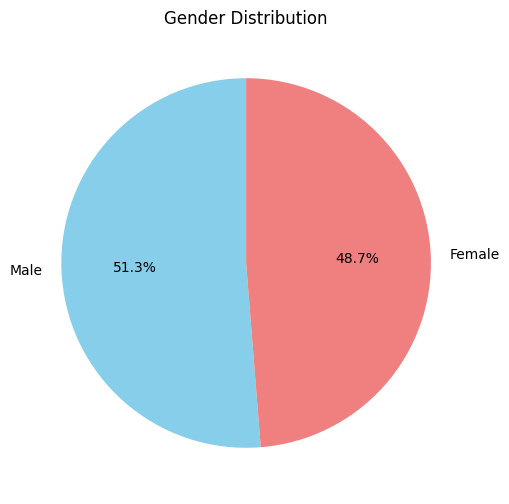

模型回答: 已成功生成性别分布情况的饼图。请查看图表以获取可视化结果。


In [74]:
chat_with_inter(functions_list=functions_list, 
                prompt="请将telco_db数据库中的user_demographics表保存到本地Python环境中，并命名为user_demographics_df", 
                model=model, 
                system_message=[{"role": "system", "content": md_content}], 
                auto_run = False)

In [ ]:
import os
import chromadb
import openai
import tiktoken
from chromadb.config import Settings

# ---------------- 配置区域 ----------------

# 2. 设置存放小说的文件夹路径
NOVEL_FOLDER = "F:\文\文\文档"  # 请确保这里存放了你的 .txt 小说文件

# 3. 设置 Embedding 模型
EMBEDDING_MODEL = "text-embedding-v3"
# 注意：Chroma 集成 OpenAI 需要安装：pip install chromadb-openai
# 如果没有安装这个扩展，也可以手动调用 OpenAI 的 Embedding API，代码逻辑一样

# 4. 设置切片的最大 Token 数量
CHUNK_SIZE = 1000  # 每个切片大约 500 个 tokens
from openai import OpenAI
# 5. Chroma 数据库名称
COLLECTION_NAME = "novel_collection"
client = OpenAI(
    api_key="sk-dd65d754d561467fa8e43efd803dfbc0",
    base_url="https://dashscope.aliyuncs.com/compatible-mode/v1"  # 注意：新版SDK推荐使用 base_url 而不是 api_base
)
# ---------------- 功能实现 ----------------

def num_tokens_from_string(string: str, model_name: str) -> int:
    """计算字符串的 Token 数量"""
    encoding = tiktoken.encoding_for_model(model_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

def split_text_into_chunks(text, max_tokens=CHUNK_SIZE, overlap=50):
    """
    将长文本切分成较小的块。
    overlap: 块之间的重叠 Token 数，为了保持上下文连贯性。
    """
    encoding = tiktoken.encoding_for_model("gpt-3.5-turbo") # 用于计算的模型
    
    chunks = []
    current_chunk = ""
    current_length = 0
    
    # 按段落简单切分，然后再合并到指定 Token 数
    paragraphs = text.split('\n\n')
    
    for para in paragraphs:
        para_len = num_tokens_from_string(para, "gpt-3.5-turbo")
        
        if current_length + para_len > max_tokens:
            # 如果加上这段话超了，先保存当前块
            if current_chunk:
                chunks.append(current_chunk.strip())
            # 开启新块
            current_chunk = para + "\n\n"
            current_length = para_len
        else:
            # 累加到当前块
            current_chunk += para + "\n\n"
            current_length += para_len
            
    # 处理最后剩余的内容
    if current_chunk:
        chunks.append(current_chunk.strip())
        
    return chunks

def init_chroma_db():
    """
    初始化 Chroma 数据库。
    如果不存在，则创建新的；如果存在，则加载。
    """
    # 使用持久化存储，这样下次启动不需要重新构建索引
    client = chromadb.PersistentClient(path="./chroma_db", settings=Settings(allow_reset=True))
    
    # 获取或创建 Collection
    try:
        collection = client.get_collection(name=COLLECTION_NAME)
        print(f"成功加载已有的 Chroma 集合，当前包含 {collection.count()} 个文档块。")
    except:
        # ... (前面的代码不变) ...

    # 创建 Collection 时修复 metadata 参数
        collection = client.create_collection(
            name=COLLECTION_NAME,
            metadata={
    "hnsw:space": "cosine",
    "hnsw:M": 16
}

        )

        print(f"创建新的 Chroma 集合：{COLLECTION_NAME}")
    
    return client, collection

# ... (前面的代码导入不变)
import os

# ... (其他导入)

# ... (build_novel_index 函数定义)

def build_novel_index(collection, folder_path):
    print(f"正在扫描文件夹: {folder_path} ...")
    
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
            file_path = os.path.join(folder_path, filename)
            print(f"正在处理: {filename}")
            
            # --- 修改这里：先尝试 utf-8，如果失败则尝试 gbk ---
            try:
                # 第一次尝试：默认 UTF-8
                with open(file_path, 'r', encoding='utf-8') as f:
                    full_text = f.read()
            except UnicodeDecodeError:
                # 如果 UTF-8 失败，捕获异常并尝试 GBK
                print(f"  -> UTF-8 解码失败，尝试使用 GBK 编码...")
                try:
                    with open(file_path, 'r', encoding='gbk') as f:
                        full_text = f.read()
                except Exception as e:
                    # 如果 GBK 也失败，跳过该文件
                    print(f"  -> GBK 解码也失败，跳过文件 {filename}。错误: {e}")
                    continue
            except Exception as e:
                # 处理其他打开文件的错误（如权限问题）
                print(f"  -> 读取文件出错，跳过 {filename}。错误: {e}")
                continue
            # ----------------------------------------------------
            
            # 切分文本
            try:
                chunks = split_text_into_chunks(full_text)
            except Exception as e:
                print(f"  -> 切分文本出错，跳过 {filename}。错误: {e}")
                continue

            # ... (前面的代码不变)

            for i, chunk in enumerate(chunks):
                if len(chunk.strip()) == 0:
                    continue
                
                # --- 修改这里：兼容阿里云和标准 OpenAI ---
                try:
                    response = client.embeddings.create(
                        input=chunk,
                        model=EMBEDDING_MODEL
                    )
                    
                    # 修正：尝试处理不同的返回格式
                    # 方案：如果 response 是对象且有 model_dump_json 方法，转为字典；如果是字典直接取
                    if hasattr(response, 'model_dump_json'):
                        # 阿里云兼容模式通常有这个方法
                        import json
                        response_dict = json.loads(response.model_dump_json())
                        embedding = response_dict['data'][0]['embedding']
                    elif isinstance(response, dict):
                        # 标准 OpenAI 字典格式
                        embedding = response['data'][0]['embedding']
                    else:
                        # 尝试直接作为对象访问（针对某些版本）
                        embedding = response.data[0].embedding
                    chunk_id = f"{filename}_{i}"
                    
                    collection.add(
                        ids=[chunk_id],                 # <--- 1. 新增：显式传入 ID 列表
                        embeddings=[embedding],          # <--- 2. 向量列表
                        documents=[chunk],               # <--- 3. 文档列表
                        metadatas=[{"source_file": filename, "chunk_id": i}] # <--- 4. 元数据列表
                    )
                except Exception as e:
                    print(f"  -> 向量化或存入失败，跳过块 {i}。错误: {e}")
                    continue
            # ----------------------------------------------------

# ... (后面的代码不变)

    print(f"索引构建完成！当前数据库包含 {collection.count()} 个文本块。")


def search_novels(query, collection, top_k=3):
    """
    在 Chroma 中搜索最相关的小说片段
    """
    print(f"正在向量数据库中搜索: {query} ...")
    
    # 1. 查询向量化 (Chroma 会自动处理，或者我们需要手动处理)
    # Chroma 的 query 默认会将查询文本转向量（如果配置了 embedding_function）。
    # 为了简单起见，这里我们让 Chroma 自动处理查询（需要确保配置正确）。
    # 如果没有配置自动转向量，需要手动调用 OpenAI API 传入 query_embeddings
    
    results = collection.query(
        query_texts=[query],
        n_results=top_k
    )
    
    # 2. 整理结果
    # results['documents'] 是匹配到的文本内容
    # results['metadatas'] 是对应的元数据 (包含我们存的 source_file)
    
    context_parts = []
    source_files = set() # 使用集合去重，确保返回唯一的文件名
    
    for i, (doc, meta) in enumerate(zip(results['documents'][0], results['metadatas'][0])):
        # 过滤掉距离太远的不相关内容 (Chroma 返回的距离是 L2 距离，越小越相似)
        # Chroma 的 'distances' 默认不返回，如果需要可以配置，这里我们假设前 top_k 都是相关的
        # 如果需要过滤，可以计算距离阈值。
        
        # 提取来源文件名
        file_name = meta['source_file']
        source_files.add(file_name)
        
        context_parts.append(f"【来源 {i+1}：文件《{file_name}》】\n{doc}\n")
    
    # 合并上下文和来源信息
    combined_context = "\n".join(context_parts)
    unique_sources = list(source_files)
    
    return combined_context, unique_sources

def ask_llm_with_sources(question, context, sources):
    """
    将问题和检索到的上下文及来源文件名组合，发给 OpenAI。
    强制 LLM 在回答时引用来源。
    """
    # 构建来源列表字符串
    sources_str = "、".join([f"《{s}》" for s in sources])
    
    prompt = f"""
    你是一个专业的小说阅读助手。
    用户根据他的本地小说库询问了一个问题。
    请根据下面提供的“小说片段”和“来源文件”列表，回答用户的问题。
    
    **重要要求：**
    1. 你的回答必须严格基于提供的“小说片段”。
    2. 在回答的开头，请明确指出：“根据文件 {sources_str} 中的内容...”。
    3. 如果提供的片段中没有答案，请直接说“提供的小说片段中未包含相关信息”。
    
    小说片段：
    {context}
    
    用户问题：{question}
    
    请回答：
    """
    
    try:
        response = client.chat.completions.create(
            model="deepseek-v3",
            messages=[
                {"role": "system", "content": "你是一个严谨的文学助手，只根据提供的证据回答，并注明来源。"},
                {"role": "user", "content": prompt}
            ],
            temperature=0.3
        )
        return response.choices[0].message.content
    except Exception as e:
        return f"请求出错: {e}"


In [2]:
import os
import chromadb
import tiktoken
from openai import OpenAI
from chromadb.config import Settings
from chromadb.utils import embedding_functions

# ---------------- 配置区域 ----------------

# 1. 设置存放小说的文件夹路径 (建议使用双斜杠或原生字符串 r"" 防止转义)
NOVEL_FOLDER = r"F:\文\文\文档" 

# 2. 设置阿里云 API Key
# 建议设为环境变量: set DASHSCOPE_API_KEY=你的Key
API_KEY = os.getenv("DASHSCOPE_API_KEY", "sk-dd65d754d561467fa8e43efd803dfbc0")

# 3. 设置 Embedding 模型 (注意：必须与 chroma 使用的函数一致)
EMBEDDING_MODEL = "text-embedding-v3"

# 4. 设置切片的最大 Token 数量
CHUNK_SIZE = 1000  # 每个切片最大 tokens

# 5. Chroma 数据库名称
COLLECTION_NAME = "novel_collection"

# 6. 设置对话模型 (修正：使用阿里云支持的模型名)
CHAT_MODEL = "qwen-plus" # 可选: qwen-turbo, qwen-plus, qwen-max

# ---------------- 初始化 OpenAI 客户端 (指向阿里云) ----------------
client = OpenAI(
    api_key=API_KEY,
    base_url="https://dashscope.aliyuncs.com/compatible-mode/v1"
)

# ---------------- 核心修复：自定义 Embedding Function ----------------
class AliyunEmbeddingFunction(embedding_functions.EmbeddingFunction):
    def __init__(self, api_key, base_url, model_name):
        self.client = OpenAI(api_key=api_key, base_url=base_url)
        self.model_name = model_name

    def __call__(self, input_texts):
        # 将文本转为向量
        response = self.client.embeddings.create(
            input=input_texts,
            model=self.model_name
        )
        # 提取向量列表
        # 处理对象格式
        if hasattr(response, 'model_dump_json'):
            import json
            response_dict = json.loads(response.model_dump_json())
            return [item['embedding'] for item in response_dict['data']]
        else:
            return [item.embedding for item in response.data]

# 创建 embedding function 实例
aliyun_embed_fn = AliyunEmbeddingFunction(
    api_key=API_KEY,
    base_url="https://dashscope.aliyuncs.com/compatible-mode/v1",
    model_name=EMBEDDING_MODEL
)

# ---------------- 功能实现 ----------------

def num_tokens_from_string(string: str) -> int:
    """计算字符串的 Token 数量 (使用通用 cl100k_base 编码)"""
    encoding = tiktoken.get_encoding("cl100k_base")
    return len(encoding.encode(string))

def split_text_into_chunks(text, max_tokens=CHUNK_SIZE, overlap=50):
    """
    将长文本切分成较小的块。
    """
    encoding = tiktoken.get_encoding("cl100k_base") # 修正：使用通用编码
    
    chunks = []
    current_chunk = ""
    current_length = 0
    
    # 按段落简单切分
    paragraphs = text.split('\n\n')
    
    for para in paragraphs:
        para_len = num_tokens_from_string(para)
        
        if current_length + para_len > max_tokens:
            if current_chunk:
                chunks.append(current_chunk.strip())
            current_chunk = para + "\n\n"
            current_length = para_len
        else:
            current_chunk += para + "\n\n"
            current_length += para_len
            
    if current_chunk:
        chunks.append(current_chunk.strip())
        
    return chunks

def init_chroma_db():
    """
    初始化 Chroma 数据库，并绑定 Aliyun Embedding Function
    """
    client_db = chromadb.PersistentClient(path="./chroma_db", settings=Settings(allow_reset=True))
    
    collection = None
    try:
        # 尝试获取已有集合
        collection = client_db.get_collection(name=COLLECTION_NAME, embedding_function=aliyun_embed_fn)
        print(f"成功加载已有的 Chroma 集合，当前包含 {collection.count()} 个文档块。")
    except Exception:
        # 不存在则创建，关键：传入 embedding_function
        collection = client_db.create_collection(
            name=COLLECTION_NAME,
            metadata={"hnsw:space": "cosine"},
            embedding_function=aliyun_embed_fn # <--- 核心修复：确保查询时也用这个函数
        )
        print(f"创建新的 Chroma 集合：{COLLECTION_NAME}")
    
    return client_db, collection

def build_novel_index(collection, folder_path):
    print(f"正在扫描文件夹: {folder_path} ...")
    
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
            file_path = os.path.join(folder_path, filename)
            print(f"正在处理: {filename}")
            
            # 读取文件 (兼容 UTF-8 和 GBK)
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    full_text = f.read()
            except UnicodeDecodeError:
                print(f"  -> UTF-8 解码失败，尝试使用 GBK 编码...")
                try:
                    with open(file_path, 'r', encoding='gbk') as f:
                        full_text = f.read()
                except Exception as e:
                    print(f"  -> GBK 解码也失败，跳过文件 {filename}。错误: {e}")
                    continue
            except Exception as e:
                print(f"  -> 读取文件出错，跳过 {filename}。错误: {e}")
                continue
            
            # 切分文本
            try:
                chunks = split_text_into_chunks(full_text)
            except Exception as e:
                print(f"  -> 切分文本出错，跳过 {filename}。错误: {e}")
                continue

            for i, chunk in enumerate(chunks):
                if len(chunk.strip()) == 0:
                    continue
                
                try:
                    # 注意：因为我们在 collection 上绑定了 embedding_function，
                    # 理论上可以只传 documents，让 Chroma 自动 embedding。
                    # 但为了代码逻辑清晰（以及绕过某些版本的 bug），我们这里手动计算 embedding。
                    
                    response = client.embeddings.create(
                        input=chunk,
                        model=EMBEDDING_MODEL
                    )
                    
                    if hasattr(response, 'model_dump_json'):
                        import json
                        response_dict = json.loads(response.model_dump_json())
                        embedding = response_dict['data'][0]['embedding']
                    else:
                        embedding = response.data[0].embedding
                    
                    chunk_id = f"{filename}_{i}"
                    
                    collection.add(
                        ids=[chunk_id],
                        embeddings=[embedding], # 传入手动计算的向量
                        documents=[chunk],
                        metadatas=[{"source_file": filename, "chunk_id": i}]
                    )
                except Exception as e:
                    print(f"  -> 向量化或存入失败，跳过块 {i}。错误: {e}")
                    continue
            
    print(f"索引构建完成！当前数据库包含 {collection.count()} 个文本块。")

def search_novels(query, collection, top_k=3):
    """
    在 Chroma 中搜索。
    因为 collection 初始化时绑定了 embedding_function，这里直接传文本即可。
    """
    print(f"正在向量数据库中搜索: {query} ...")
    
    # 核心修复：直接使用 query_texts，Chroma 会自动调用我们传入的 aliyun_embed_fn
    results = collection.query(
        query_texts=[query],
        n_results=top_k
    )
    
    context_parts = []
    source_files = set()
    
    # 检查结果是否为空
    if not results['documents'] or not results['documents'][0]:
        return "", []

    for i, (doc, meta) in enumerate(zip(results['documents'][0], results['metadatas'][0])):
        file_name = meta['source_file']
        source_files.add(file_name)
        context_parts.append(f"【来源 {i+1}：文件《{file_name}》】\n{doc}\n")
    
    combined_context = "\n".join(context_parts)
    return combined_context, list(source_files)

def ask_llm_with_sources(question, context, sources):
    """
    将问题发给阿里云 LLM (qwen-plus)。
    """
    sources_str = "、".join([f"《{s}》" for s in sources])
    
    prompt = f"""
    你是一个专业的小说阅读助手。
    用户根据他的本地小说库询问了一个问题。
    请根据下面提供的“小说片段”和“来源文件”列表，回答用户的问题。
    
    **重要要求：**
    1. 你的回答必须严格基于提供的“小说片段”。
    2. 在回答的开头，请明确指出：“根据文件 {sources_str} 中的内容...”。
    3. 如果提供的片段中没有答案，请直接说“提供的小说片段中未包含相关信息”。
    
    小说片段：
    {context}
    
    用户问题：{question}
    
    请回答：
    """
    
    try:
        response = client.chat.completions.create(
            model=CHAT_MODEL, # 修正：使用 qwen-plus
            messages=[
                {"role": "system", "content": "你是一个严谨的文学助手，只根据提供的证据回答，并注明来源。"},
                {"role": "user", "content": prompt}
            ],
            temperature=0.3
        )
        return response.choices[0].message.content
    except Exception as e:
        return f"请求出错: {e}"

def main():
    # 0. (可选) 如果想重置数据库，取消下面这行的注释
    # client_db.reset() 

    # 1. 初始化数据库 (传入 Embedding Function)
    client_db, collection = init_chroma_db()
    
    # 2. 检查索引是否存在，不存在则构建
    if collection.count() == 0:
        print("数据库为空，开始构建小说向量数据库...")
        build_novel_index(collection, NOVEL_FOLDER)
    else:
        print("数据库已有数据，跳过构建。如需重新构建，请删除 ./chroma_db 文件夹。")
    
    # 3. 交互循环
    print("\n小说本地检索系统已就绪！(输入 'quit' 退出)")
    while True:
        user_query = input("\n请输入你想查询关于小说的内容：")
        if user_query.lower() in ['quit', 'exit', 'q']:
            break
        
        # A. 搜索
        relevant_context, source_files = search_novels(user_query, collection, top_k=15)
        
        if not relevant_context:
            print("抱歉，数据库中没有找到相关的小说片段。")
            continue
            
        print(f"--- 检索到相关片段 (来源文件：{source_files}) ---\n{relevant_context}\n----------------------")
        
        # B. 问答
        print("正在让 AI 分析片段并生成回答...")
        answer = ask_llm_with_sources(user_query, relevant_context, source_files)
        
        print(f"\n助手回答：\n{answer}")

if __name__ == "__main__":
    main()


Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given


成功加载已有的 Chroma 集合，当前包含 493 个文档块。
数据库已有数据，跳过构建。如需重新构建，请删除 ./chroma_db 文件夹。

小说本地检索系统已就绪！(输入 'quit' 退出)
正在向量数据库中搜索: 新婚媳妇被公婆管教、立规矩、责罚 ...


Failed to send telemetry event CollectionQueryEvent: capture() takes 1 positional argument but 3 were given


--- 检索到相关片段 (来源文件：['3《足下的恋人》作者：易修罗.txt', '11骄阳似火BY瑶心魅(1).txt', 'Family作者：筱糖（兄弟训诫）.txt']) ---
【来源 1：文件《11骄阳似火BY瑶心魅(1).txt》】
第48章   打起来了2
轩辕夫人见到自己宝贝女儿的样子差点眼皮一翻晕过去，阿雅可是他们全家人的眼珠子，什么时候受过这种侮辱和委屈，上前赶紧把人扶起来心肝心肝的叫
突然凶狠的瞪向阿宝“夫人，你是否该给本夫人一个交代，你凭什么将我女儿打成这样？”
“嘿”阿宝皮笑肉不笑的看向她“你怎么不问问你女儿为什么挨打？”说完脸色一冷“本夫人好歹是一品夫人，她不过是世家小姐便也敢对本夫人大呼小叫，本夫人到是想问问你们轩辕府的体统何在？如此以下犯上，目无尊卑，是不是连当朝皇上也不放在眼里了”一番义正言辞的呵斥，铿锵有力，威严冷冽
顿时，所有人呆在原地，刚刚这孩子不还憨厚娇软，这才转个身怎么这么厉害了，那股天生的威严傲气生生令人升出敬畏
赶来的南安王妃掩唇轻笑，这还有什么怀疑的，先不说那张脸与弟妹那样的像，光是那脾气，还有那打架的刁钻劲，手黑劲，简直和凌柏小时候一模一样
“我什么时候冒犯你了，是你侮辱曼文姐姐，她有什么错，她有什么错”轩辕雅找到了靠山，歇斯底里的喊着
阿宝嗤嗤一笑“我侮辱她？你要记住，人要被辱，必先自辱，她若没有那些龌蹉的心思我就是想侮辱她还找不到借口呢”扬了扬头，软糯的语气颇显无赖
轩辕夫人气的再一次仰倒，拉住还想扑上去的轩辕雅似笑非笑“丞相夫人果然伶牙俐齿，我们轩辕府自是惹不起你，不过，我倒是要看看，相爷是不是就这般骄纵当家夫人，居然敢虐打名门贵女”威胁一番，拉着挣扎不休的轩辕雅气怒离开
南安王妃这才上前“好了好了，不过是小孩子家打打闹闹，都散了吧”将那些看热闹的疏散，这才转头看向阿宝“你呀”无奈的戳了戳她的脑门“好歹也是嫁了人的，怎么就这么不知规矩，行了，跟我先回去吧，我请人让莫言来接你”拉着阿宝又原路转回
阿宝一听要让楼莫言来接她，顿时苦了脸“王妃，我能不能在你府中主上几日”抱着对方胳膊，又成了一开始的憨傻娇软样
“哈哈”南安王妃被她顿时取乐，拍着手愉悦大笑
楼莫言赶到南安王府，直接先去拜见了南安王，书房里，两人也不知道谈了些什么，等楼莫言出来时明显松了口气，神色轻快了很多
一进客厅，就看到南安王妃笑容艳艳，而自家阿宝低